In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

## Загрузка исходных данных

In [2]:
pd.set_option('display.max_columns', 60)

In [3]:
data = pd.read_csv('data/Energy_and_Water_Data_Disclosure_for_Local_Law_84_2017__Data_for_Calendar_Year_2016_.csv')
data.head()

Order  Property Id                                 Property Name  \
0      1        13286                                       201/205   
1      2        28400                    NYP Columbia (West Campus)   
2      3      4778226                                 MSCHoNY North   
3      4      4778267  Herbert Irving Pavilion & Millstein Hospital   
4      5      4778288                               Neuro Institute   

  Parent Property Id        Parent Property Name  BBL - 10 digits  \
0              13286                     201/205     1.013160e+09   
1              28400  NYP Columbia (West Campus)     1.021380e+09   
2              28400  NYP Columbia (West Campus)     1.021380e+09   
3              28400  NYP Columbia (West Campus)     1.021390e+09   
4              28400  NYP Columbia (West Campus)     1.021390e+09   

  NYC Borough, Block and Lot (BBL) self-reported  \
0                                     1013160001   
1                                   1-02138-0040   
2                                   1-02138-0030   
3                                   1-02139-0001   
4                                   1-02139-0085   

            NYC Building Identification Number (BIN)  \
0                                            1037549   
1  1084198; 1084387;1084385; 1084386; 1084388; 10...   
2                                            1063380   
3                                   1087281; 1076746   
4                                            1063403   

  Address 1 (self-reported)                Address 2 Postal Code  \
0  201/205  East  42nd  st.            Not Available       10017   
1          622 168th Street            Not Available       10032   
2             3975 Broadway            Not Available       10032   
3   161 Fort Washington Ave  177 Fort Washington Ave       10032   
4     710 West 168th Street            Not Available       10032   

   Street Number           Street Name    Borough  DOF Gross Floor Area  \
0          675.0              3 AVENUE  Manhattan              289356.0   
1          180.0  FT WASHINGTON AVENUE  Manhattan             3693539.0   
2         3975.0              BROADWAY  Manhattan              152765.0   
3          161.0  FT WASHINGTON AVENUE  Manhattan              891040.0   
4          193.0  FT WASHINGTON AVENUE  Manhattan              211400.0   

   Primary Property Type - Self Selected  \
0                                 Office   
1  Hospital (General Medical & Surgical)   
2  Hospital (General Medical & Surgical)   
3  Hospital (General Medical & Surgical)   
4  Hospital (General Medical & Surgical)   

  List of All Property Use Types at Property  \
0                                     Office   
1      Hospital (General Medical & Surgical)   
2      Hospital (General Medical & Surgical)   
3      Hospital (General Medical & Surgical)   
4      Hospital (General Medical & Surgical)   

               Largest Property Use Type  \
0                                 Office   
1  Hospital (General Medical & Surgical)   
2  Hospital (General Medical & Surgical)   
3  Hospital (General Medical & Surgical)   
4  Hospital (General Medical & Surgical)   

   Largest Property Use Type - Gross Floor Area (ft²)  \
0                                           293447.0    
1                                          3889181.0    
2                                           231342.0    
3                                          1305748.0    
4                                           179694.0    

  2nd Largest Property Use Type  \
0                 Not Available   
1                 Not Available   
2                 Not Available   
3                 Not Available   
4                 Not Available   

  2nd Largest Property Use - Gross Floor Area (ft²)  \
0                                     Not Available   
1                                     Not Available   
2                                     Not Available   
3                                     Not Available   
4  

## Очистка и подготовка данных

In [4]:
print('Размер таблицы: {}'.format(data.shape))

Размер таблицы: (11746, 60)


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11746 entries, 0 to 11745
Data columns (total 60 columns):
Order                                                         11746 non-null int64
Property Id                                                   11746 non-null int64
Property Name                                                 11746 non-null object
Parent Property Id                                            11746 non-null object
Parent Property Name                                          11746 non-null object
BBL - 10 digits                                               11695 non-null float64
NYC Borough, Block and Lot (BBL) self-reported                11746 non-null object
NYC Building Identification Number (BIN)                      11746 non-null object
Address 1 (self-reported)                                     11746 non-null object
Address 2                                                     11746 non-null object
Postal Code                                         

Видно, что: 
* а)Необходимо определить отсутствующие значения как Nan

* б)Необходимо изменить тип некоторых данных на числовой 

* в)В данных много пропусков, необходимо будет отобрать подходящие по полноте данных признаки 

In [6]:
data = data.replace({'Not Available': np.nan})

In [7]:
numeric_columns = []
for col in data.columns:
    if ('ft²' in col or 'kBtu' in col or 'Metric Tons CO2e' in col or 'kWh' in 
        col or 'therms' in col or 'gal' in col or 'Score' in col):
        numeric_columns.append(col)
data[numeric_columns] = data[numeric_columns].astype(float)       

Определим признаки, которые слишком бедны информацией для дальнейшего анализа. Пороговое значение полноты - 50%.
Воспользуемся функцией

In [8]:
def get_missing_values_priority(df, sort = True, threshold = 50, print_text = True):
    '''
    Функция строит таблицу полноты данных для заданного датафрейма
    Принимает на вход исходный датафреймю. 
    Парметры: sort (Нужна ли сортировка итоговой таблицы или нет, по умолчанию - да)
              threshold (Пороговое процентное значение пригодности признака для вывода в отчете, по умолчанию - 50)
    Возвращает сводную таблицу и печатает краткий отчет
    '''
    missing_val_amount = data.isnull().sum(axis=0).values
    missing_val_percent = 100*missing_val_amount/len(df)
    result_df = pd.DataFrame({'Title': df.columns, 
                              'Null values amount':missing_val_amount,
                              '% of Null values': missing_val_percent})
    result_df.set_index('Title', inplace = True)
    
    weak_features_amount = 0
    for item in missing_val_percent:
        if item > threshold:
            weak_features_amount+=1
    if print_text:
        print ('Общее число признаков для анализа: ', len(df.columns))
        print ('Число признаков пригодных для дальнейшего анализа: ', len(df.columns) - weak_features_amount)
    if sort:
        result_df = result_df.sort_values('% of Null values', axis = 0, ascending = True)
        return result_df
    else:
        return result_df
    

In [9]:
get_missing_values_priority(data)

Общее число признаков для анализа:  60
Число признаков пригодных для дальнейшего анализа:  49


Null values amount  \
Title                                                                    
Order                                                                0   
List of All Property Use Types at Property                           0   
Primary Property Type - Self Selected                                0   
Year Built                                                           0   
Number of Buildings - Self-reported                                  0   
Occupancy                                                            0   
Release Date                                                         0   
Address 1 (self-reported)                                            0   
Postal Code                                                          0   
Parent Property Name                                                 0   
Parent Property Id                                                   0   
Property Name                                                        0   
Property Id                                                          0   
Property GFA - Self-Reported (ft²)                                   0   
Largest Property Use Type                                            2   
Largest Property Use Type - Gross Floor Area (ft²)                   2   
NYC Borough, Block and Lot (BBL) self-reported                      11   
DOF Benchmarking Submission Status                                  30   
BBL - 10 digits                                                     51   
Metered Areas (Energy)                                              57   
Indirect GHG Emissions (Metric Tons CO2e)                           65   
Total GHG Emissions (Metric Tons CO2e)                              74   
Direct GHG Emissions (Metric Tons CO2e)                             83   
Borough                                                            118   
Water Required?                                                    118   
DOF Gross Floor Area                                               118   
Street Name                                                        122   
NYC Building Identification Number (BIN)                           162   
Source EUI (kBtu/ft²)                                              163   
Site EUI (kBtu/ft²)                                                163   
Electricity Use - Grid Purchase (kBtu)                             244   
Weather Normalized Site Electricity (kWh)                          786   
Weather Normalized Site Electricity Intensity (...                 787   
Natural Gas Use (kBtu)                                            1442   
Weather Normalized Site EUI (kBtu/ft²)                            1465   
Weather Normalized Source EUI (kBtu/ft²)                          1465   
Weather Normalized Site Natural Gas Use (therms)                  1962   
Weather Normalized Site Natural Gas Intensity (...                1963   
ENERGY STAR Score                                                 2104   
Street Number                                                     2186   
NTA                                                               2263   
Council District                                                  2263   
Community Board                                                   2263   
Longitude                                                         2263   
Latitude                                                          2263   
Census Tract                                                      2263   
Water Use (All Water Sources) (kgal)                              3984   
Water Intensity (All Water Sources) (gal/ft²)                     3984   
Metered Areas  (Water)                                            4609   
2nd Largest Property Use - Gross Floor Area (ft²)                 8005   
2nd Largest Property Use Type                                     8005   
Fuel Oil #2 Use (kBtu)                                            9165   
3rd Largest Property Use Type - Gross Floor Are...      

Удалим признаки по результатам функции

In [10]:
percent_table = get_missing_values_priority(data, print_text = False)
drop_list = percent_table[percent_table['% of Null values']>50].index.values


In [11]:
data = data.drop(columns = drop_list, axis = 0)

In [12]:
data.shape

(11746, 49)

Рассмотрим распределения отфильтрованных признаков на наличие аномалий

In [13]:
def draw_subplot_grid():
    fig = plt.figure(figsize = (15, 70))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    for i in range(1, 31):
        ax = fig.add_subplot(11, 3, i)
        x = data.select_dtypes(include = 'number').iloc[:, i-1:i].dropna().values
        label = data.select_dtypes(include = 'number').iloc[:, i-1:i].dropna().columns[0]
        ax.hist(x, bins = 50)
        ax.set_title(label)


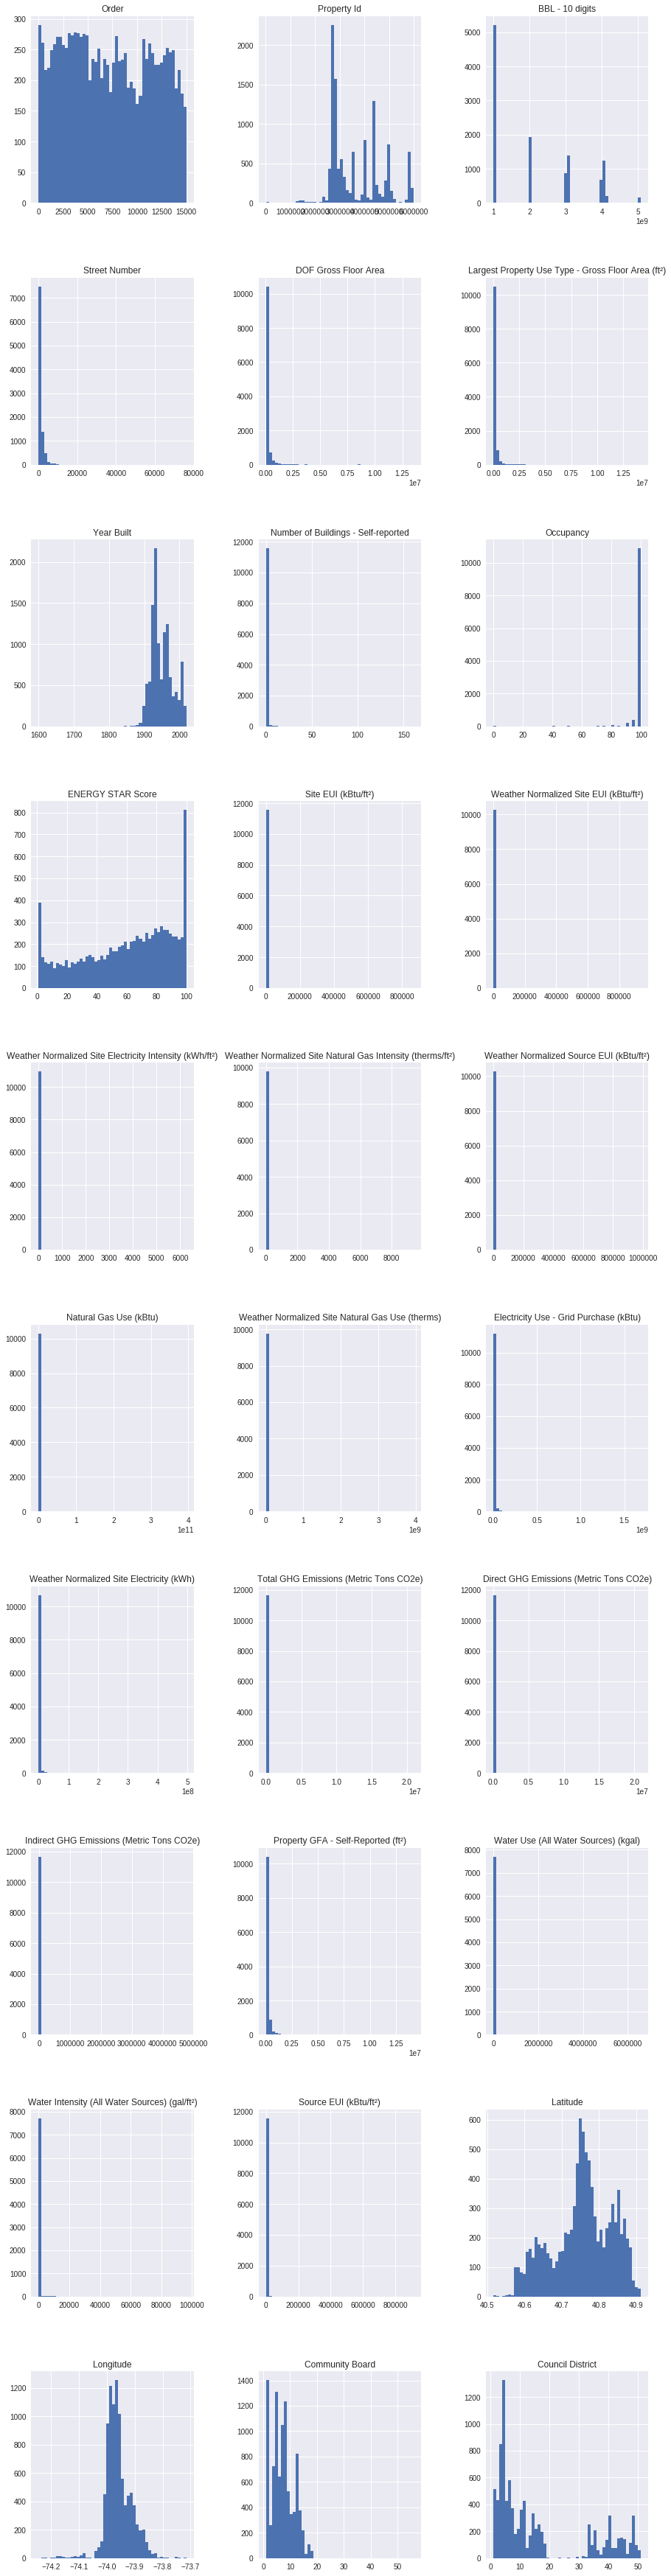

In [14]:
draw_subplot_grid()

Вопросы вызывают признаки начиная с  Site EUI по Sourse EUI. Начнем с EUI признаков. Учитывая, что Site EUI показывает суммарное использование энергии по отношеню к квадратному футу площади, то будем работать с ним.

In [15]:
data['Site EUI (kBtu/ft²)'].dropna().describe()

count     11583.000000
mean        280.071484
std        8607.178877
min           0.000000
25%          61.800000
50%          78.500000
75%          97.600000
max      869265.000000
Name: Site EUI (kBtu/ft²), dtype: float64

In [16]:
np.set_printoptions(suppress=True)
data['Site EUI (kBtu/ft²)'].dropna().sort_values().tail(100).values

array([   391.6,    392.7,    393.5,    394.8,    399.3,    400.3,
          400.5,    408.9,    408.9,    413.4,    421. ,    424.7,
          430.8,    437.9,    440. ,    440.4,    442.3,    446.5,
          448.1,    454.3,    457.1,    469.2,    469.7,    475.5,
          482. ,    504.7,    510. ,    524.9,    529.3,    536.5,
          536.7,    545. ,    546.5,    548.4,    555.8,    556.4,
          565.5,    568.9,    570.5,    608.8,    623.1,    631.8,
          640.1,    697.9,    721.6,    749.7,    822.1,    858.7,
          903.2,    918.9,    929. ,    930.7,    992.6,   1000.6,
         1005.1,   1029.7,   1138.3,   1145.6,   2001.8,   2025.2,
         2564.4,   3576.6,   3995.4,   4377.4,   4651.5,   4770. ,
         5972.3,   8084.2,   8311.8,   9915.6,  12316.2,  13145.4,
        14195.9,  15059.3,  16519.6,  17133.2,  17193.4,  18235.7,
        18368.1,  18459.5,  19313.5,  22259. ,  24541.2,  25789.4,
        26451.7,  28373.6,  34326.8,  49340.7,  50621.6,  5082

Видно, что естественное распределение признака "забивается" выбросом, максимальное его значение - 869265.
Удалим аномалии из данных. Будем считать аномальными величины выходящие за следующие границы квартилей: (Q1  - 3*IQ) и (Q3 + 3*IQ)

In [17]:
first_quartile = data['Site EUI (kBtu/ft²)'].describe()['25%']
third_quartile = data['Site EUI (kBtu/ft²)'].describe()['75%']
iqr = third_quartile  - first_quartile
data = data[(data['Site EUI (kBtu/ft²)'] > (first_quartile - 3*iqr)) &
            (data['Site EUI (kBtu/ft²)'] < (third_quartile + 3*iqr))]

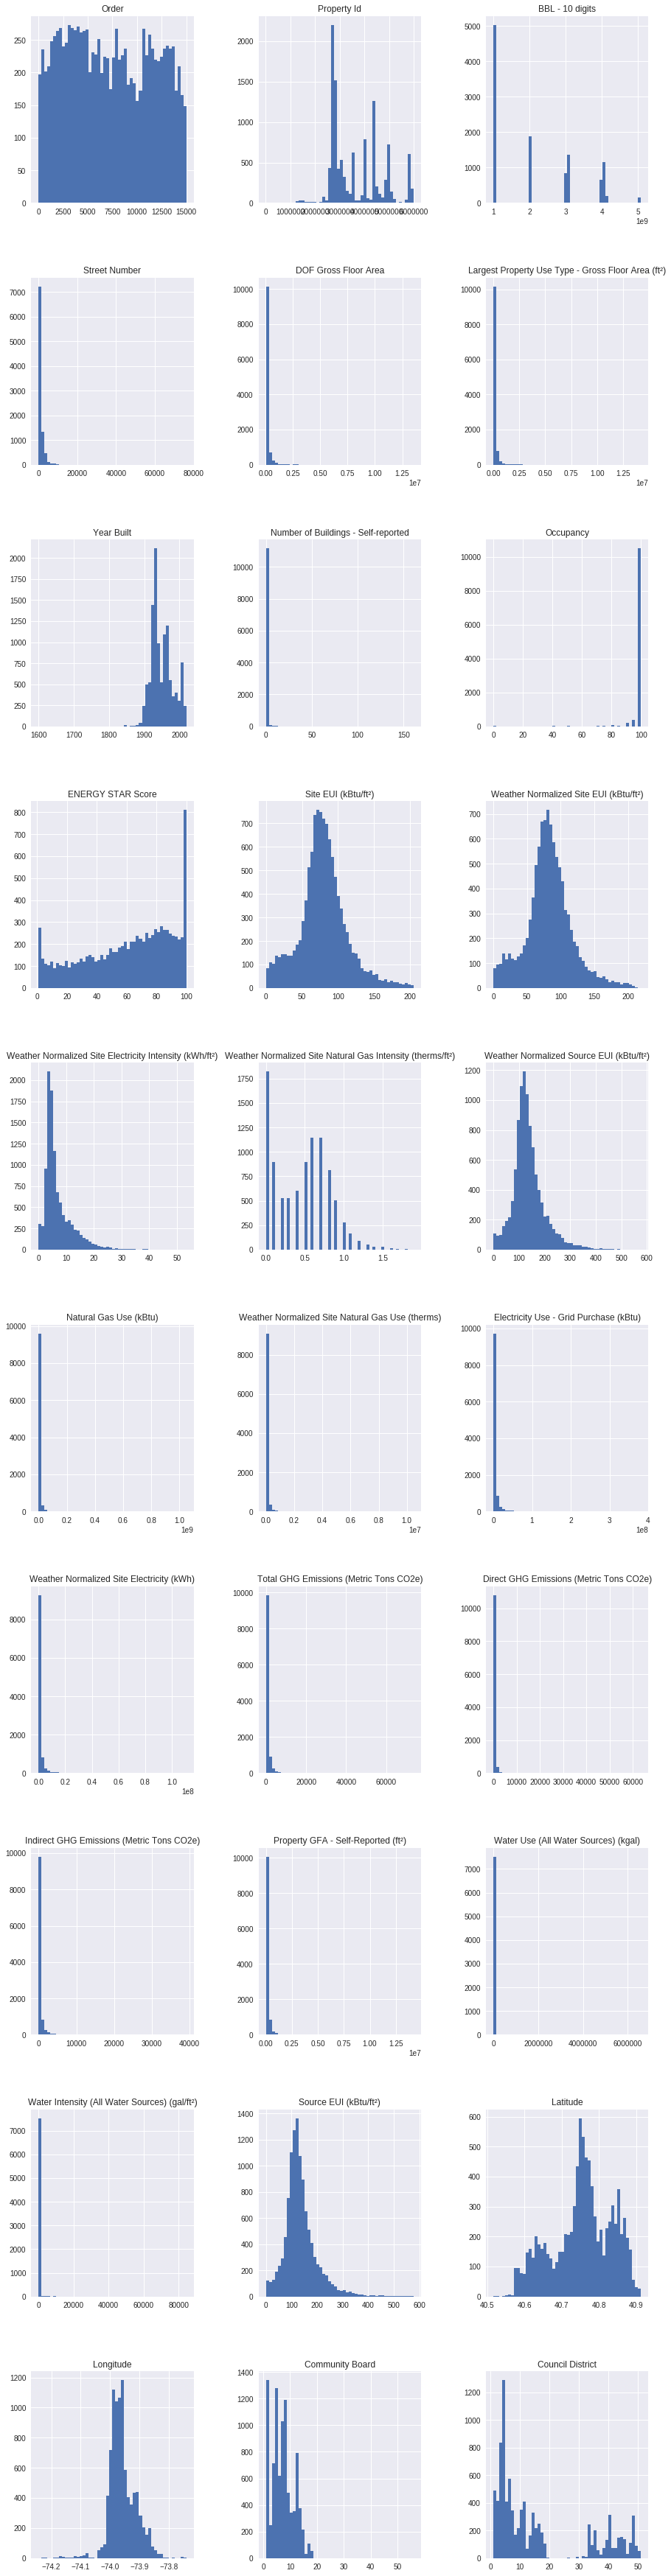

In [18]:
draw_subplot_grid()

In [19]:
data.shape

(11319, 49)

Признаки связанные с EUI исправились, рассмотрим распределния связанные с потреблением ресурсов.

Потребление газа:

In [20]:
data['Natural Gas Use (kBtu)'].dropna().describe()

count    1.006400e+04
mean     6.319034e+06
std      1.849371e+07
min      0.000000e+00
25%      1.053560e+06
50%      4.045754e+06
75%      6.707841e+06
max      1.048344e+09
Name: Natural Gas Use (kBtu), dtype: float64

In [21]:
# data['Natural Gas Use (kBtu)'].dropna().sort_values().tail(1000).values

Потребление электричества:

In [22]:
data['Electricity Use - Grid Purchase (kBtu)'].dropna().describe()

count    1.123300e+04
mean     4.896294e+06
std      1.247223e+07
min      0.000000e+00
25%      1.036544e+06
50%      1.817050e+06
75%      4.176568e+06
max      3.815670e+08
Name: Electricity Use - Grid Purchase (kBtu), dtype: float64

In [23]:
# data['Electricity Use - Grid Purchase (kBtu)'].dropna().sort_values().tail(1000).values

Потребление воды:

In [24]:
data['Water Use (All Water Sources) (kgal)'].dropna().describe()

count    7.573000e+03
mean     1.488663e+04
std      1.468339e+05
min      0.000000e+00
25%      2.589000e+03
50%      4.665700e+03
75%      7.941300e+03
max      6.594604e+06
Name: Water Use (All Water Sources) (kgal), dtype: float64

In [25]:
# data['Water Use (All Water Sources) (kgal)'].dropna().sort_values().tail(1000).values

Эмиссия углекислого газа:

In [26]:
data['Total GHG Emissions (Metric Tons CO2e)'].dropna().describe()

count    11316.000000
mean       946.171704
std       1995.343381
min          0.000000
25%        329.000000
50%        495.700000
75%        868.825000
max      73694.900000
Name: Total GHG Emissions (Metric Tons CO2e), dtype: float64

In [27]:
#data['Total GHG Emissions (Metric Tons CO2e)'].dropna().sort_values().tail(1000).values

Подозрения вызывают показатели связанные с водой и углекислым газом. Применим аналогичный фильтр.

*Терялось слишком много данных - порядка 4300 записей из 11300. В половине случаев они не имели значения score, но как-то это слишком. Похоже что нужно эти промышленные здания в отдельную модель выносить. Иначе при сравнении с другими помещениями они забивают их своими значениями, а выкидывать их тоже не правильно.*

In [28]:
# first_quartile_w = data['Water Use (All Water Sources) (kgal)'].describe()['25%']
# third_quartile_w = data['Water Use (All Water Sources) (kgal)'].describe()['75%']
# iqr_w = third_quartile_w  - first_quartile_w

# first_quartile_e = data['Total GHG Emissions (Metric Tons CO2e)'].describe()['25%']
# third_quartile_e = data['Total GHG Emissions (Metric Tons CO2e)'].describe()['75%']
# iqr_e = third_quartile_e  - first_quartile_e


# data = data[(data['Water Use (All Water Sources) (kgal)'] > (first_quartile_w - 3*iqr_w)) &
#             (data['Water Use (All Water Sources) (kgal)'] < (third_quartile_w + 3*iqr_w)) &
#             (data['Total GHG Emissions (Metric Tons CO2e)'] > (first_quartile_e - 3*iqr_e)) &
#             (data['Total GHG Emissions (Metric Tons CO2e)'] < (third_quartile_e + 3*iqr_e))]   
           

In [29]:
# draw_subplot_grid()

In [30]:
data.shape

(11319, 49)

## Первичное изучение данных (Explorary Data Analysis, EDA)

Оценим распределение целевого признака

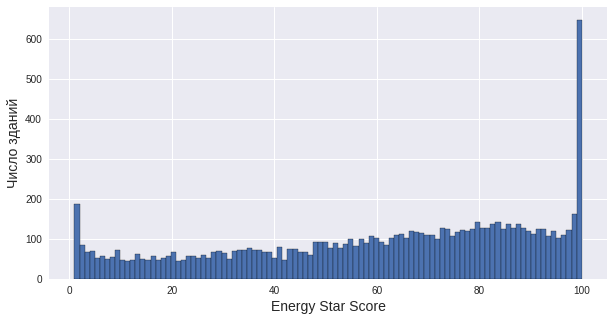

In [31]:
data['ENERGY STAR Score'].dropna().hist(bins = 100, edgecolor = 'black', figsize = (10, 5))  
plt.xlabel('Energy Star Score', fontsize=14);
plt.ylabel('Число зданий', fontsize=14);
                                        

Видно, что в распределении аномально большое число максимальных оценок. Они могут быть объяснены тем, что их  ставят сами владельцы зданий. 

*Примечание: до фильтрации данных через квартили, в распределении так же присутствовало аномально большое число минимальных оценок. Я связываю это с тем, что оценивали старые, промышленные здания.*

In [32]:
data = data.rename(columns = {'ENERGY STAR Score': 'score'}) #переименуем столбец, слишком громоздкое название

In [33]:
# Возможно здания с такими экстремальными оценками можно кластеризовать в отдельную группу по каким-то признакам

**Оценим взаимосвязи между категориальными признаками и целевым**

Оценим как меняется распределние Energy Star Score в зависимости от типа эксплуатируемого помещения

In [34]:
types = data.dropna(subset = ['score']) #dropna строк, где Nan только в столбце score
types = types['Largest Property Use Type'].value_counts()

In [35]:
types

Multifamily Housing                      7464
Office                                   1157
Hotel                                     202
Non-Refrigerated Warehouse                156
K-12 School                                97
Residence Hall/Dormitory                   96
Senior Care Community                      85
Distribution Center                        61
Retail Store                               57
Medical Office                             23
Hospital (General Medical & Surgical)      15
Financial Office                           12
Supermarket/Grocery Store                  10
Worship Facility                            9
Refrigerated Warehouse                      8
Wholesale Club/Supercenter                  3
Parking                                     3
Courthouse                                  2
Bank Branch                                 1
Name: Largest Property Use Type, dtype: int64

Примем пороговое значение равное 50

In [36]:
property_types = list(types[types.values > 50].index)

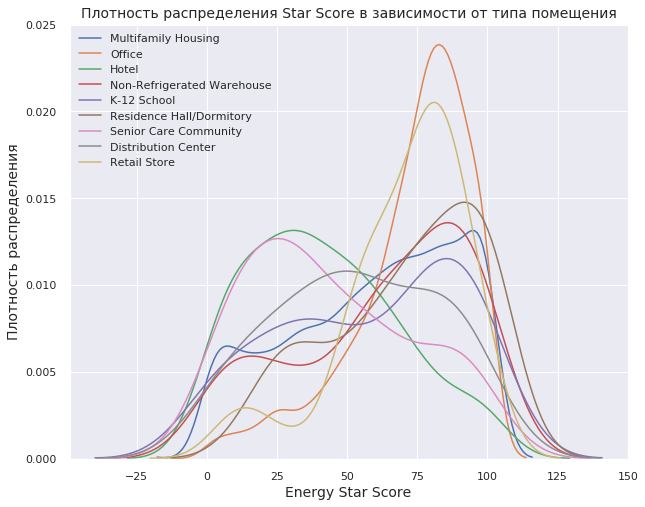

In [37]:
sns.set(rc={'figure.figsize':(10,8)})
for p_type in property_types:
    subset = data[data['Largest Property Use Type'] == p_type]
    sns.kdeplot(subset['score'].dropna(), label = p_type)

plt.xlabel('Energy Star Score', size = 14); plt.ylabel('Плотность распределения', size = 14); 
plt.title('Плотность распределения Star Score в зависимости от типа помещения', size = 14);

Видно,что признак оказывает значительное влияние. В будущем его стоит использовать для построения модели (one-hot-encoding)

Аналогично оценим как меняется распределние Energy Star Score в зависимости от района (Borough)

In [38]:
boroughs = data.dropna(subset = ['score'])
boroughs = boroughs['Borough'].value_counts()
boroughs

Manhattan        3985
Brooklyn         1947
Queens           1707
Bronx            1655
Staten Island     119
Name: Borough, dtype: int64

In [39]:
boroughs_types = list(boroughs.index)

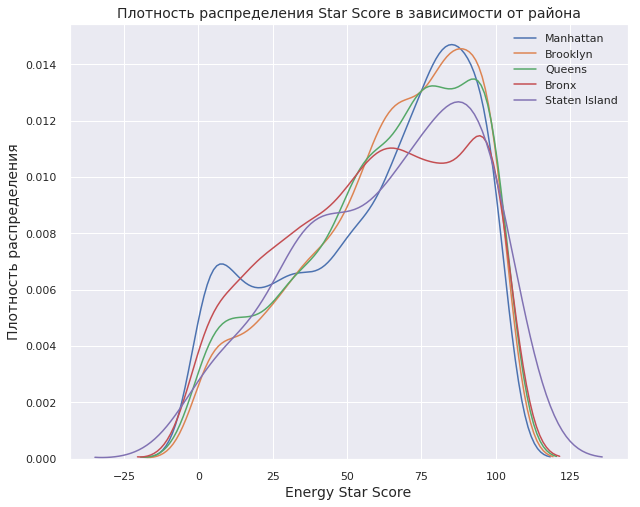

In [40]:
for b_type in boroughs_types:
    subset = data[data['Borough'] == b_type]
    sns.kdeplot(subset['score'].dropna(), label = b_type)

plt.xlabel('Energy Star Score', size = 14); 
plt.ylabel('Плотность распределения', size = 14); 
plt.title('Плотность распределения Star Score в зависимости от района', size = 14);

Здесь результаты не столь значительны

In [41]:
# На будущее - осмотреть какие еще вещественные признаки могут быть использованы. 
#Если их много - сделать функцию-генератор, в которую подать список этих параметров и 
# отрисовать сетку таких графиков

In [42]:
data.shape

(11319, 49)

**Оценим корреляции между числовыми признаками и целевым**

In [43]:
correlations = data.corr().score.sort_values()

In [44]:
correlations

Site EUI (kBtu/ft²)                                          -0.723864
Weather Normalized Site EUI (kBtu/ft²)                       -0.713993
Weather Normalized Source EUI (kBtu/ft²)                     -0.645542
Source EUI (kBtu/ft²)                                        -0.641037
Weather Normalized Site Electricity Intensity (kWh/ft²)      -0.358394
Weather Normalized Site Natural Gas Intensity (therms/ft²)   -0.346046
Direct GHG Emissions (Metric Tons CO2e)                      -0.147792
Weather Normalized Site Natural Gas Use (therms)             -0.135211
Natural Gas Use (kBtu)                                       -0.133648
Year Built                                                   -0.121249
Total GHG Emissions (Metric Tons CO2e)                       -0.113136
Electricity Use - Grid Purchase (kBtu)                       -0.050639
Weather Normalized Site Electricity (kWh)                    -0.048207
Latitude                                                     -0.048196
Proper

## Создание и отбор признаков

План:
* Сгенерировать полный набор признаков:
  * Для категориальных признаков -  one-hot encoding
  * Для числовых - добавить производные признаки от корня и логарифма
* Отфильтровать мультиколлинеарные признаки (порог равен 0.6)
* Применить PCA для формирования итогового набора

Подберем наиболее перспективные признаки из существующих, плюс добавим новые - создадим их с помощью взятия корня или натурального логарифма от числовых признаков.

In [45]:
#expand numbers of numerical features
numeric_subset = data.select_dtypes('number')
for col in numeric_subset.columns:
    if col == 'score':
        next
    else:
        numeric_subset.loc[:, 'sqrt_' + col] = np.sqrt(numeric_subset[col])
        #numeric_subset.loc[:, 'log_' + col] = np.log(numeric_subset[col])
        
# one-hot-encoding categorical features       
categorical_subset = data[['Borough', 'Largest Property Use Type']]
categorical_subset = pd.get_dummies(categorical_subset)

features = pd.concat([numeric_subset, categorical_subset], axis = 1).dropna(subset = ['score'])
expanded_correlations = features.corr()['score'].dropna().sort_values()

/home/grigoriy/anaconda3/envs/basic_env/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/grigoriy/anaconda3/envs/basic_env/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/grigoriy/anaconda3/envs/basic_env/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys


In [46]:
print('Итоговое число признаков: {}'.format(features.shape[1]))

Итоговое число признаков: 114


In [47]:
expanded_correlations.head(15)

Site EUI (kBtu/ft²)                                               -0.723864
Weather Normalized Site EUI (kBtu/ft²)                            -0.713993
sqrt_Site EUI (kBtu/ft²)                                          -0.699817
sqrt_Weather Normalized Site EUI (kBtu/ft²)                       -0.689019
sqrt_Weather Normalized Source EUI (kBtu/ft²)                     -0.671044
sqrt_Source EUI (kBtu/ft²)                                        -0.669396
Weather Normalized Source EUI (kBtu/ft²)                          -0.645542
Source EUI (kBtu/ft²)                                             -0.641037
sqrt_Weather Normalized Site Electricity Intensity (kWh/ft²)      -0.406669
Weather Normalized Site Electricity Intensity (kWh/ft²)           -0.358394
Weather Normalized Site Natural Gas Intensity (therms/ft²)        -0.346046
sqrt_Weather Normalized Site Natural Gas Intensity (therms/ft²)   -0.288024
sqrt_Direct GHG Emissions (Metric Tons CO2e)                      -0.285695
sqrt_Natural

In [48]:
expanded_correlations.tail(15)

sqrt_Order                                                         0.028662
Borough_Queens                                                     0.029545
Largest Property Use Type_Supermarket/Grocery Store                0.030038
Largest Property Use Type_Residence Hall/Dormitory                 0.035407
Order                                                              0.036827
Largest Property Use Type_Hospital (General Medical & Surgical)    0.048410
sqrt_BBL - 10 digits                                               0.049363
BBL - 10 digits                                                    0.049963
Borough_Brooklyn                                                   0.050486
Community Board                                                    0.056612
sqrt_Community Board                                               0.058029
sqrt_Council District                                              0.060623
Council District                                                   0.061639
Largest Prop

Видно, что преобразованные через корень или логарифм признаки зачастую показывают более устойчивую корреляцию, нежели чем свои исходные признаки. Наиболее интересным признаком по-прежнему является Site EUI (kBtu/ft²). 

Оценим корреляцию некоторых признаков визуально. Отобразим данные для ранее отобранных групп зданий.

In [49]:
graph_features = features.copy() 

In [50]:
graph_features['Largest Property Use Type'] = data.dropna(subset = ['score'])['Largest Property Use Type']

#ограничим выборку отобранными ранее типами зданий (property_types)
graph_features = graph_features[graph_features['Largest Property Use Type'].isin(property_types)]

In [51]:
def draw_two_variable_plot(feature_name):
    sns.lmplot(feature_name, 'score', hue = 'Largest Property Use Type',
               data = graph_features, fit_reg = False, height = 8, scatter_kws = {'alpha': 0.5, 's': 30})
    plt.xlabel(feature_name, size = 14);
    plt.ylabel('Energy Star Score', size = 14);
    plt.title('Cвязь между {} и Energy Star Score'.format(feature_name), size = 14)

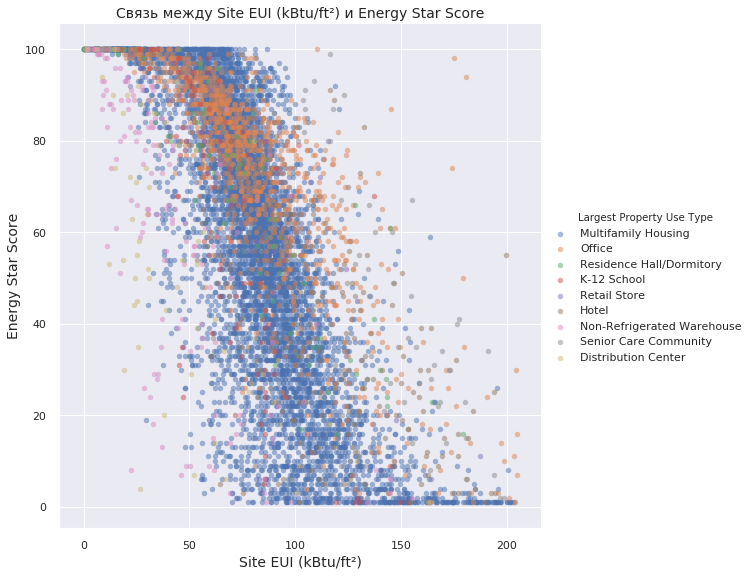

In [52]:
draw_two_variable_plot('Site EUI (kBtu/ft²)')

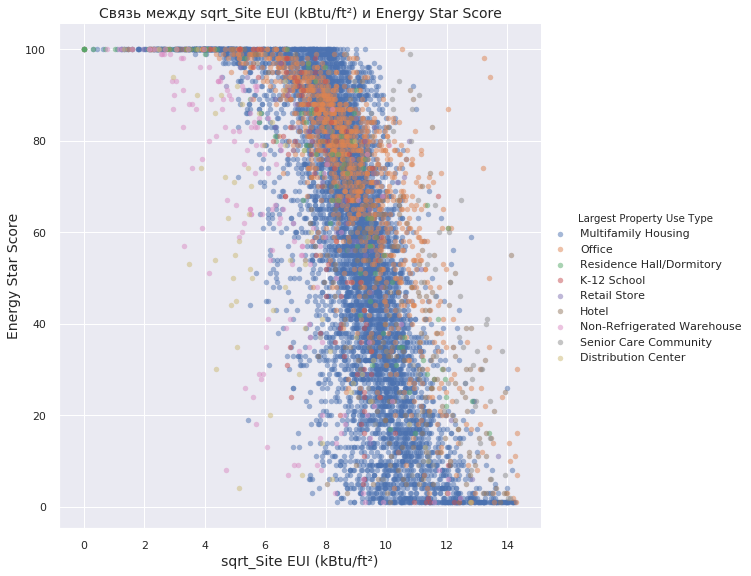

In [53]:
draw_two_variable_plot('sqrt_Site EUI (kBtu/ft²)')

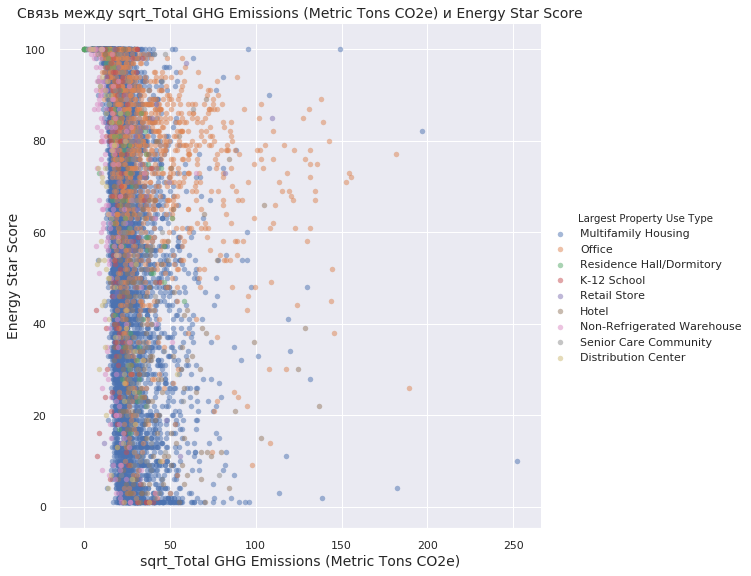

In [54]:
draw_two_variable_plot('sqrt_Total GHG Emissions (Metric Tons CO2e)')

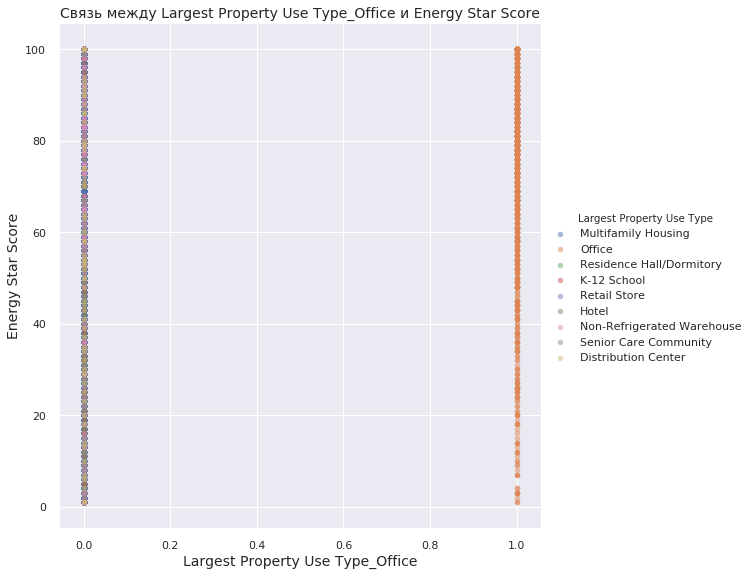

In [55]:
draw_two_variable_plot('Largest Property Use Type_Office')

**Удалим коллинеарные признаки**

In [56]:
def get_collinear_names(df, threshold):
    y = df['score']
    x = df.drop(columns = ['score'])
    corr_matrix = x.corr()
    
    drop_list = []
    
    for i in range(len(corr_matrix)):
        for j in range(len(corr_matrix)):
            item = corr_matrix.iloc[j, i]
            if i >= j:
                continue
            else:
                if np.abs(item) > 0.5 or item == np.nan:
                    drop_list.append(corr_matrix.columns[i])
    return list(set(drop_list))



In [57]:
drop_list = get_collinear_names(df = features, threshold = 0.6)
cleaned_features  = features.drop(columns = drop_list).dropna(axis = 1, how = 'all')


In [58]:
print('Число признаков до фильтрации: {}'.format(features.shape[1]))
print('Число признаков после фильтрации: {}'.format(cleaned_features.shape[1]))

Число признаков до фильтрации: 114
Число признаков после фильтрации: 64


In [59]:
cleaned_features.corr()['score'].sort_values().head()

sqrt_Source EUI (kBtu/ft²)                           -0.669396
sqrt_Direct GHG Emissions (Metric Tons CO2e)         -0.285695
sqrt_Year Built                                      -0.120866
Largest Property Use Type_Hotel                      -0.096428
sqrt_Water Intensity (All Water Sources) (gal/ft²)   -0.080333
Name: score, dtype: float64

In [60]:
cleaned_features.corr()['score'].sort_values().dropna().tail()

Largest Property Use Type_Hospital (General Medical & Surgical)    0.048410
Borough_Brooklyn                                                   0.050486
sqrt_Community Board                                               0.058029
Largest Property Use Type_Office                                   0.158484
score                                                              1.000000
Name: score, dtype: float64

In [61]:
# Получается, что алгоритм удалил самые интресные чистые признаки, оставив их производные с корнями. 
#Нужно подправить.

**Применим PCA сжатие для уменьшения размерности данных. Сохраним 99% дисперсии**

Проверим, есть ли строки с пропущенными значениями score

In [62]:
no_score = cleaned_features[cleaned_features['score'].isna()]
score = cleaned_features[cleaned_features['score'].notnull()]

print(no_score.shape)
print(score.shape)

(0, 64)
(9461, 64)


In [68]:
features = score.drop(columns = 'score')
features = features.replace({np.inf: np.nan, -np.inf: np.nan})

targets = pd.DataFrame(score['score'])

train_features, test_features, y, y_test = train_test_split(features, targets, test_size = 0.3, random_state = 42)

print(train_features.shape)
print(test_features.shape)
print(y.shape)
print(y_test.shape)

(6622, 63)
(2839, 63)
(6622, 1)
(2839, 1)


In [95]:
imputer = SimpleImputer(strategy = 'median')
imputer.fit(train_features)

X = imputer.transform(train_features)
X_test = imputer.transform(test_features)

In [96]:
pca = PCA(n_components = 0.99)
print('Число признаков до PCA сжатия: {}'.format(X.shape[1]))
X = pca.fit_transform(X)
X_test = pca.transform(X_test)
print('Число признаков после PCA сжатия: {}'.format(X.shape[1]))

Число признаков до PCA сжатия: 63
Число признаков после PCA сжатия: 3


Наивное решение:

In [98]:
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

In [99]:
baseline_guess = np.median(y)

print(mae(y_test, baseline_guess))

score    24.483621
dtype: float64


In [102]:
# # Save the no scores, training, and testing data
# no_score.to_csv('data/no_score.csv', index = False)
# X.to_csv('data/training_features.csv', index = False)
# X_test.to_csv('data/testing_features.csv', index = False)
# y.to_csv('data/training_labels.csv', index = False)
# y_test.to_csv('data/testing_labels.csv', index = False)